In [205]:
import sys
assert sys.version_info >= (3,5)

In [206]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [207]:
import pandas as pd

In [208]:
import numpy as np

In [209]:
import scipy.stats as stats

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

In [211]:
from pandas.plotting import scatter_matrix

In [212]:
import time

In [213]:
import cv2

In [214]:
import seaborn as sns

In [215]:
import warnings
warnings.filterwarnings('ignore')

In [216]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

In [217]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [218]:
from sklearn.metrics import accuracy_score, silhouette_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

In [219]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 

In [220]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [221]:
from sklearn.model_selection import cross_val_score

In [222]:
from itertools import cycle

In [223]:
from sklearn.cluster import KMeans

In [224]:
complete_x_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_train_all.csv')
complete_y_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_train_all.csv')
complete_x_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_test_all.csv')
complete_y_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_test_all.csv')

In [225]:
# complete_x_train = complete_x_train.copy()
# complete_x_test = complete_x_test.copy()

In [226]:
dim = (48,48)

In [227]:
def contrast(arr):
    image_height = 48
    image_width = 48
    X= arr
    
    equalized_images = np.zeros((X.shape[0], image_height * image_width), dtype=np.uint8)
    
    for i in range(X.shape[0]):
        # Convert the row to a numpy array and reshape it to a 2D image
        image = X.reshape((image_height, image_width)).astype(np.uint8)  # Convert to uint8 type
    
        # Apply histogram equalization
        image_eq = cv2.equalizeHist(image)
    
        # Flatten the image back to 1D and store it
        equalized_images[i, :] = image_eq.flatten()

In [228]:
def process_image(image_path):
    # Read the image in grayscale
    pixel_array = image_path
    reshaped_array = pixel_array.reshape((48, 48)) 
    normalized_array = np.uint8(reshaped_array*255)

    image_eq = cv2.equalizeHist(normalized_array)

    # Convert the image to binary using Otsu's method
    _, binary_image = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the number from the image
    number = normalized_array[y:y+h, x:x+w]

    return [number,h, w]

In [229]:
def img_denoiser(arr): 
    pixel_array = arr
    reshaped_array = pixel_array.reshape((48, 48)) 
    normalized_array = np.uint8(reshaped_array*255)
    if normalized_array.ndim != 2:
        raise ValueError("The image should have 2 dimensions")
    
    # thresholded_image = cv2.resize(normalized_array,dim)
    thresholded_image = cv2.adaptiveThreshold(normalized_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY_INV, 11, 1)
    return thresholded_image


In [230]:
def simplify(arr):
    im = process_image(np.array(arr))
    ret = img_denoiser(cv2.resize(im[0].reshape(im[1],im[2]),(48,48)))
    return ret

In [231]:
complete_x_train_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_train.copy()).reshape(-1, dim[0]*dim[1])

complete_x_test_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_test.copy()).reshape(-1, dim[0]*dim[1])

complete_x_train_denoise = pd.DataFrame(complete_x_train_denoise)
complete_x_test_denoise = pd.DataFrame(complete_x_test_denoise)

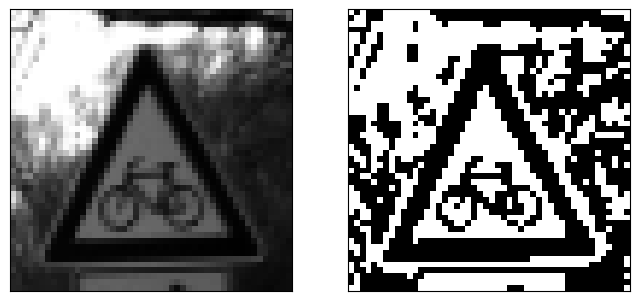

In [232]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train.iloc[9685].to_numpy().reshape(48,48),'gray')
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train_denoise.iloc[9685].to_numpy().reshape(dim),'gray')

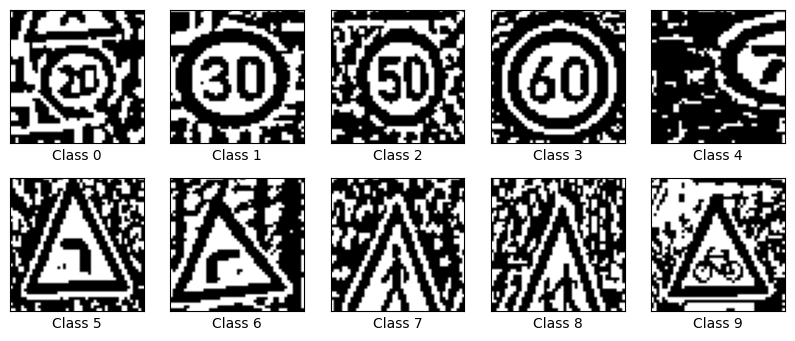

In [233]:
plt.figure(figsize=(10,4))

img_toshow = [0,210,2435,6085,7030,8275,8635,8875,9415,9685]

for i in range (0, len(img_toshow)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_train_denoise.iloc[img_toshow[i]].to_numpy().reshape(dim), cmap='gray')
    plt.xlabel("Class "+str(complete_y_train.iloc[img_toshow[i]].to_numpy()[0]))

In [234]:
joined_dataset = complete_x_train_denoise.copy()
joined_dataset['class']=complete_y_train.copy()

grouped_dataset = joined_dataset.groupby('class', group_keys=False)
avg_val = int(grouped_dataset['class'].value_counts().max())

In [235]:
balanced_dataset = pd.DataFrame()

for i in range(0,10):
        balanced_dataset = pd.concat([balanced_dataset, joined_dataset[joined_dataset['class']==i].sample(avg_val, replace=True)])

balanced_dataset_x = balanced_dataset.iloc[:,:dim[0]*dim[1]]
balanced_dataset_y = balanced_dataset.iloc[:,dim[0]*dim[1]:]

In [236]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42, n_init=10)
kmeans.fit(balanced_dataset_x)

In [ ]:
kmeans_centroids = kmeans.cluster_centers_
kmeans_centroids

array([[109.09894899, 111.84439887, 106.74570623, ..., 112.36734171,
        124.19892335, 125.17944117],
       [131.91558442, 125.84415584, 144.05844156, ..., 128.78787879,
        116.64502165, 113.33333333],
       [107.53012048, 117.54845469, 115.67836564, ..., 131.70770037,
        129.16972237, 155.48454688],
       ...,
       [ 46.75478065,  56.50731159,  39.48818898, ...,  80.98425197,
         87.19910011,  87.86839145],
       [ 31.37133183,  17.26862302,  58.13769752, ...,  68.35496614,
         11.80022573,  28.49322799],
       [102.0923913 , 106.01902174, 105.32608696, ..., 104.40217391,
        119.87771739, 118.95380435]])

In [ ]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [ ]:
y_pred = kmeans.predict(complete_x_test_denoise)

In [ ]:
y_actual = [i[0] for i in np.array(complete_y_test)]

In [ ]:
pred_results = pd.DataFrame({'actual':y_actual,'predicted':y_pred})
pred_results.head(10)

,actual,predicted
0,1,9
1,4,6
2,6,6
3,7,0
4,4,0
5,3,6
6,1,1
7,2,1
8,3,0
9,3,6


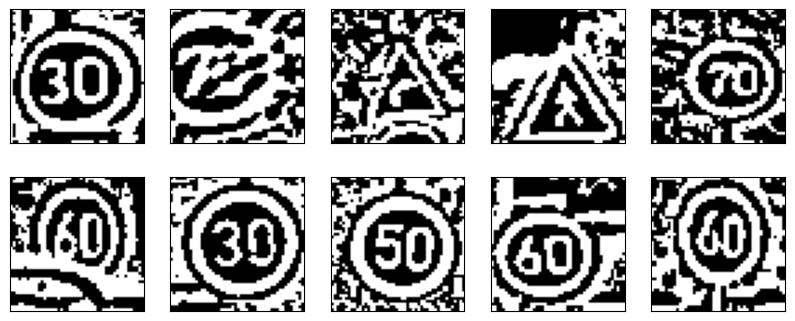

In [ ]:
plt.figure(figsize=(10,4))

for i in range (0, 10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_test_denoise.iloc[i].to_numpy().reshape(dim), cmap='gray')

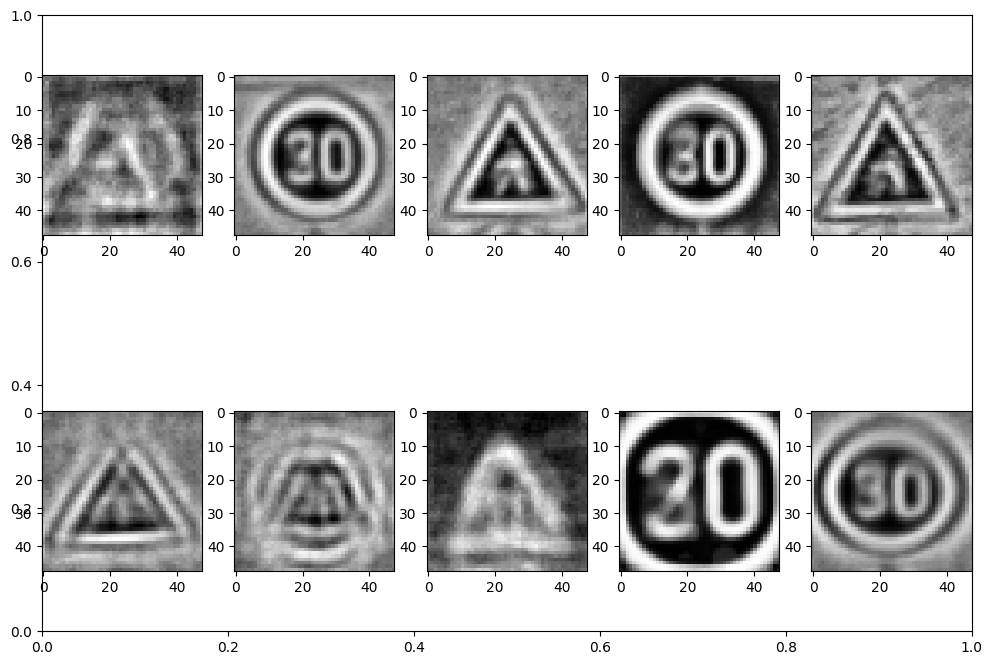

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
for centroid in range(len(kmeans_centroids)):
    plt.subplot(2,5,centroid+1)
    plt.imshow(kmeans_centroids[centroid].reshape(dim),cmap='grey')

Average silhouette score: -0.274274380027921


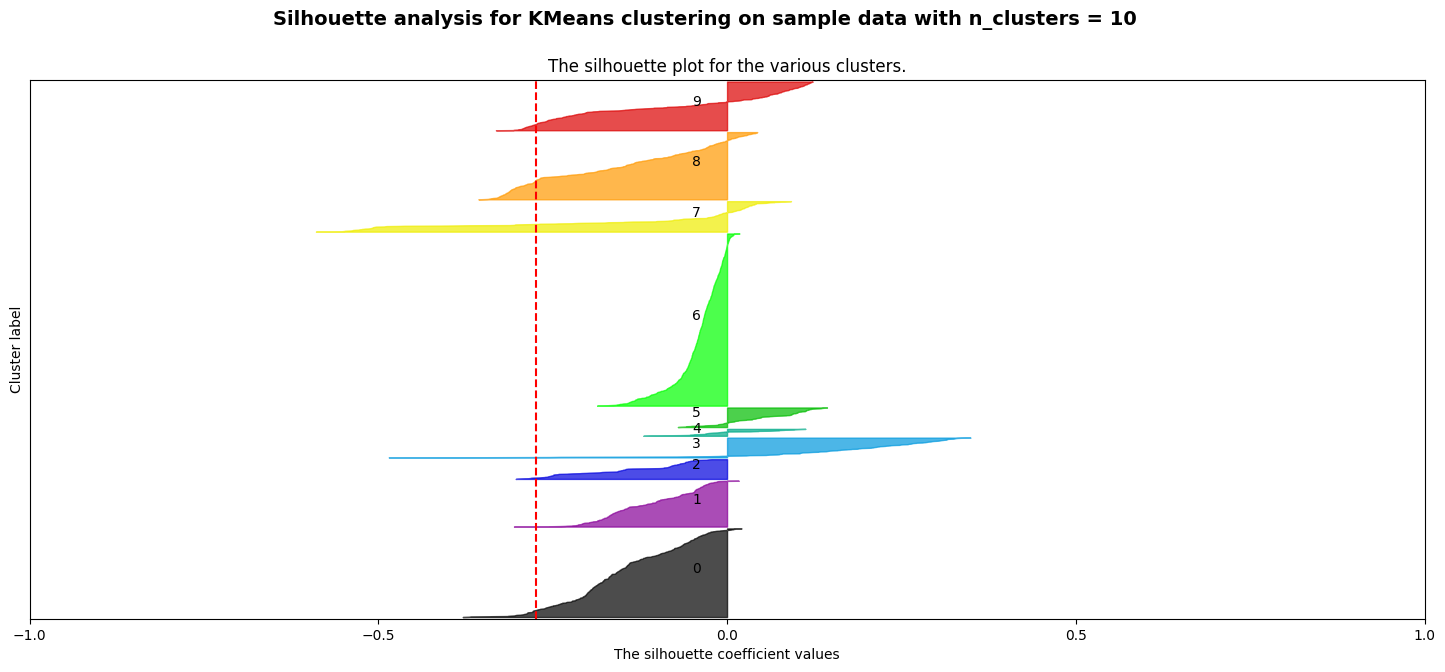

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
 
import matplotlib.cm as cm
 
# Assume 'X' is your feature matrix and 'final_assignments' are the labels from the clustering
# Ensure that 'X' is not the PCA-transformed dataset but the original feature set that was used for clustering
 
# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(complete_x_test, y_pred)
 
# Calculate the silhouette score average
silhouette_avg = silhouette_score(complete_y_test, y_pred)
print(f"Average silhouette score: {silhouette_avg}")
 
# Number of clusters
n_clusters = len(np.unique(y_pred))
 
# Create a subplot with 1 row and 1 column
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
 
# The silhouette plot ranges from -1 to 1
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
ax1.set_ylim([0, len(complete_x_test) + (n_clusters + 1) * 10])
 
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[y_pred == i]
    ith_cluster_silhouette_values.sort()
 
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
 
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
 
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
 
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
 
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
 
plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
             fontsize=14, fontweight='bold')
 
plt.show()